In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Empty the cache
    torch.cuda.empty_cache()
    # Print the memory summary
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
# import libraries
import os
import torch
import numpy as np
import pandas as pd
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def create_df(base_dir, labeled=True):
    """
    Create a dataframe from the directory of images
    Args:
        base_dir: str: the base directory of the images
        labeled: bool: whether the images are labeled or not
    Returns:
        pd.DataFrame: a dataframe with the images and labels
    """
    # create a dictionary to store the images and labels
    if labeled:
        dd = {"images": [], "labels": []}
        for i in os.listdir(base_dir):
            img_dirs = os.path.join(base_dir, i)
            for j in os.listdir(img_dirs):
                img = os.path.join(img_dirs, j)
                dd["images"] += [img]
                dd["labels"] += [i]

    else:
        dd = {"images": []}
        for i in os.listdir(base_dir):
            img_dirs = os.path.join(base_dir, i)
            dd["images"] += [img_dirs]

    return pd.DataFrame(dd)

In [ ]:
# create the dataframes
train = create_df("./dataset/train")
val = create_df("./dataset/val")
test = create_df("./dataset/test", False)

In [ ]:
# encode the labels
le = LabelEncoder()
train["labels"] = le.fit_transform(train.loc[:, "labels"].values)
val["labels"] = le.transform(val.loc[:, "labels"].values)

In [ ]:
# Define variables
EPOCHS = 20
LR = 0.1
BATCH = 32
IM_SIZE = 224
STEP = 5
GAMMA = 0.2
DECAY = 0.9
NUM_CLASSES = train["labels"].nunique()  # 10

In [ ]:
class Clod(torch.nn.Module):
    """
    A class to create a dataset."""

    def __init__(self, data, transform=None):
        super(Clod, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        # get the image and label
        image, label = self.data.iloc[x, 0], self.data.iloc[x, -1]
        image = Image.open(image).convert("RGB")
        if self.transform is not None:
            image = self.transform(np.array(image))

        return image, label

In [ ]:
# transform the images
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((IM_SIZE, IM_SIZE)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
# create the datasets
train_ds = Clod(train, transform)
val_ds = Clod(val, transform)

In [ ]:
# create the dataloaders
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [ ]:
# select the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
# create the model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)  # load the model
num_ftrs = model.fc.in_features  # get the number of features in the last layer
for param in model.parameters():
    param.requires_grad_ = False  # freeze the layers
model.fc = torch.nn.Linear(
    num_ftrs, NUM_CLASSES
)  # change the last layer to have 10 classes
model.fc.requires_grad_ = True  # set the last layer to be trainable

In [ ]:
# move the model to the device
model = model.to(device)
# define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=GAMMA, step_size=STEP)

In [ ]:
class EarlyStopper:
    """
    A class to implement early stopping."""

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float("inf")

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
# training variables
best_model = deepcopy(model)
early_stopper = EarlyStopper(patience=3, min_delta=10)
best_acc = 0.0
acc_train = []
acc_val = []
loss_train = []
loss_val = []

# train the model
for i in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0

    for data, label in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, label = data.cuda(), label.cuda()

        out = model(data)
        loss = criterion(out, label)
        train_loss += loss.item()
        train_acc += (out.argmax(1) == label).sum().item()
        train_total += out.size(0)
        loss.backward()
        optimizer.step()

    train_loss /= train_total
    train_acc /= train_total

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_total = 0

    with torch.no_grad():
        # validation loop
        for data, label in val_dl:
            if torch.cuda.is_available():
                data, label = data.cuda(), label.cuda()

            out = model(data)
            loss = criterion(out, label)
            val_loss += loss.item()
            val_acc += (out.argmax(1) == label).sum().item()
            val_total += out.size(0)

    val_acc /= val_total
    val_loss /= val_total
    acc_train += [train_acc]
    acc_val += [val_acc]
    loss_train += [train_loss]
    loss_val += [val_loss]

    if val_acc > best_acc:
        # save the best model
        best_acc = val_acc
        best_model = deepcopy(model)

    if early_stopper.early_stop(val_loss):
        break

    print(
        "Epoch {} train loss {} acc {} val loss {} acc {}".format(
            i, train_loss, train_acc, val_loss, val_acc
        )
    )
    scheduler.step()

Epoch 1 train loss 0.026076762463365284 acc 0.7607142857142857 val loss 0.009477393347769975 acc 0.925
Epoch 2 train loss 0.0030503963040454047 acc 0.975 val loss 0.0043029519915580745 acc 0.965
Epoch 3 train loss 0.0006574196634548051 acc 0.9971428571428571 val loss 0.003873366117477417 acc 0.96
Epoch 4 train loss 0.0004876196976484997 acc 0.9971428571428571 val loss 0.005439833072014153 acc 0.955
Epoch 5 train loss 0.00029547918937169017 acc 0.9985714285714286 val loss 0.0038193566258996727 acc 0.96
Epoch 6 train loss 0.0002183363207898635 acc 0.9985714285714286 val loss 0.0035806911904364826 acc 0.96
Epoch 7 train loss 0.00011742219807014667 acc 1.0 val loss 0.0038063144497573376 acc 0.96
Epoch 8 train loss 8.795373274811677e-05 acc 1.0 val loss 0.0035852798726409675 acc 0.96
Epoch 9 train loss 9.102669149537438e-05 acc 1.0 val loss 0.0032111380342394113 acc 0.96
Epoch 10 train loss 9.197999278382797e-05 acc 1.0 val loss 0.003414698913693428 acc 0.96
Epoch 11 train loss 0.0001027466

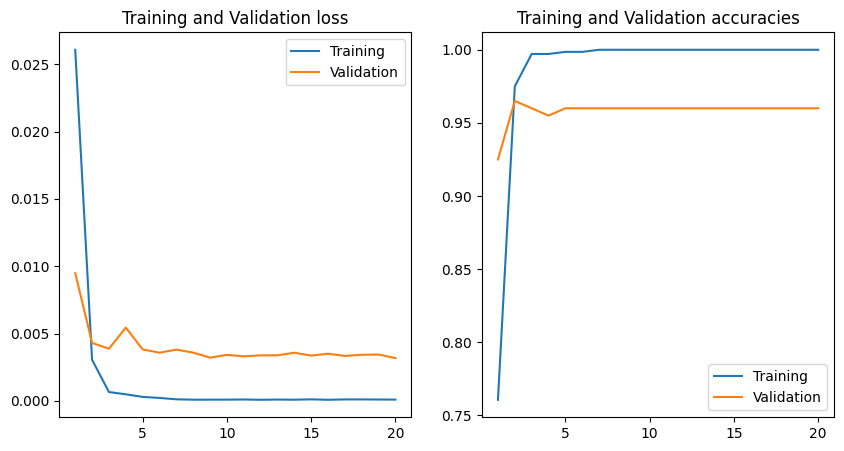

In [ ]:
# plot the results
epochs = list(range(1, EPOCHS + 1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(epochs, loss_train)
axes[0].plot(epochs, loss_val)
axes[0].set_title("Training and Validation loss")
axes[0].legend(["Training", "Validation"])
axes[1].plot(epochs, acc_train)
axes[1].plot(epochs, acc_val)
axes[1].set_title("Training and Validation accuracies")
axes[1].legend(["Training", "Validation"])
plt.show()

In [20]:
print("Best accuracy: ", best_acc)

Best accuracy:  0.965


In [ ]:
# save the best model
torch.save(best_model.state_dict(), "./best_model/best_model_resnet50.pth")

In [ ]:
# predict function
def predict(value):
    image = plt.imread(value)
    image = transform(image)
    image = image.reshape([1, image.shape[0], image.shape[1], image.shape[2]])
    if torch.cuda.is_available():
        image = image.cuda()
    best_model.eval()
    with torch.no_grad():
        out = best_model(image)
    index = out.argmax(1).item()
    return index

In [ ]:
# predict the test set
predicted = []
for i in test.iloc[:, 0]:
    predicted += [predict(i)]

In [ ]:
# decode the labels
predicted = le.inverse_transform(predicted)

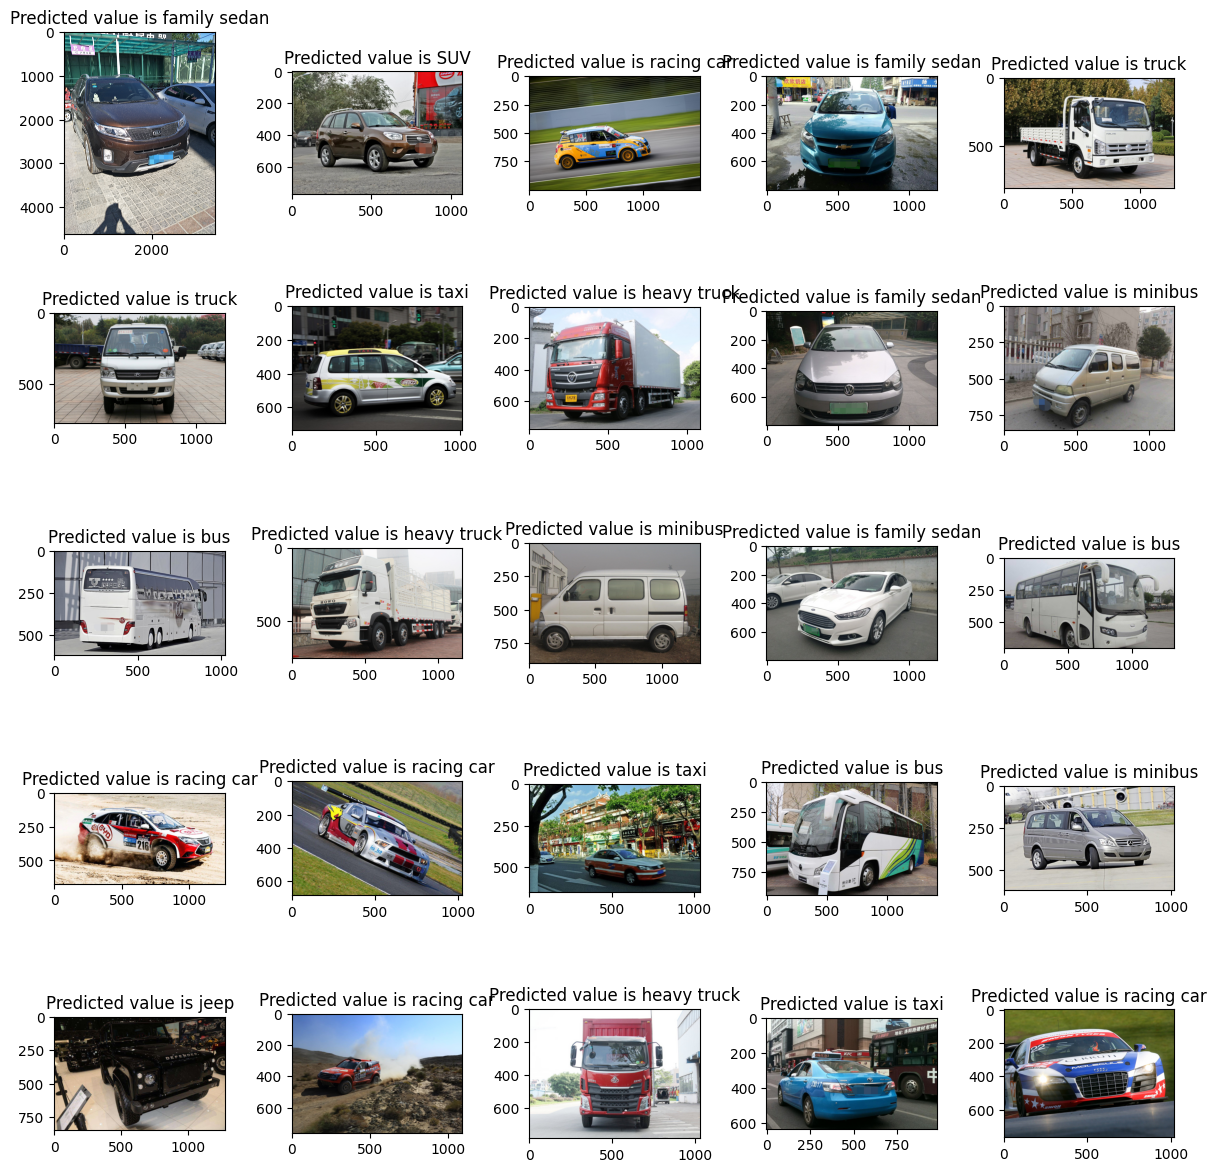

In [ ]:
# predict and plot the images
index = 0
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))
for i in range(5):
    for j in range(5):
        im = plt.imread(test.iloc[index, 0])
        axes[i][j].imshow(im)
        axes[i][j].set_title("Predicted value is {}".format(predicted[index]))
        index += 1

plt.tight_layout()
plt.show()